<a href="https://colab.research.google.com/github/sanjabh11/Projects/blob/master/Innop_AV_NLP46_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#https://github.com/IBM/support-ticket-classification/tree/master/docs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
#from fastai.callbacks import *

callbacks=[SaveBestModel(lm, name="best_lm")

## Preparing the data

In [0]:
#path = "/content/drive/My Drive/models"
path = '.'

It only contains one csv file, let's have a look at it.

In [0]:
df = pd.read_csv('train_clean22.csv')
df_test = pd.read_csv('test_clean3.csv')

In [0]:
!cp /content/train_clean22.csv '/content/drive/My Drive/models'
!cp /content/test_clean3.csv '/content/drive/My Drive/models'

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
len(df), len(df_test)

(5281, 2924)

#Numericalization


In [0]:
data.vocab.itos[:10]

In [0]:
data.train_ds[0][0]

Text xxbos xxmaj hi xxmaj claire xxmaj sounds like you 've been through the wringer a bit recently ! i would n't be surprised if the stress of everything has caused the new lesions . xxmaj but presumably xxmaj rebif has n't protected you from that , so considering switching is reasonable . i used to happily be on xxmaj rebif for a few years , and it was very effective for me . xxmaj however , it caused problems with my liver so my neuro wanted me to stop . i then switched to xxmaj tysabri , which has been excellent . xxmaj there 's two main things i like about it . xxmaj firstly , i 've been very stable on it . xxmaj and secondly , there 's been practically no side effects , other than tiredness on the day of the infusion . xxmaj however , i 've decided to stop taking it now . i 've been on it for 6 or 7 years , and i have a high level of the xxup jc virus , so i 'm at a very high risk of getting xxup pml . xxmaj it 's been the best thing i 've been on , but now the risks are a bit to 

In [0]:
data.train_ds[0][0].data[:10]

array([    2,     5,   302,     5, 12954,     5,  1274,    97,    26,   305])

In [0]:
data = (TextList.from_csv(path, 'train_clean.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

#Language model

In [0]:
df_test.head()

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara


In [0]:
data_lm = (TextList.from_csv(path, 'train_clean22.csv', cols='text')
            .split_by_rand_pct(0.1)
            .label_for_lm()
            .add_test(TextList.from_csv(path, 'test_clean3.csv', cols='text'))
            .databunch(bs=32))
#data_lm.save('data_lm.pkl')

In [0]:
data_clas = (TextList.from_csv(path, 'train_clean22.csv', cols='text', vocab=data_lm.vocab)
            #.split_from_df(col='target')
             .split_by_rand_pct(0.1)
            .label_from_df(cols='sentiment')
            .add_test(TextList.from_csv(path, 'test_clean3.csv', cols='text'))
            .databunch(bs=32))
#data_clas.save('data_clas.pkl')

In [0]:
#data_lm = load_data(path, 'data_lm.pkl')
#data_lm.show_batch(), data_clas.show_batch()

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=URLs.WT103_FWD, drop_mult=0.5)

#Training

In [0]:
bs=32

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


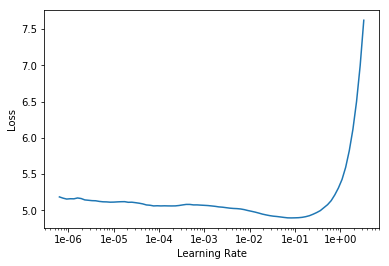

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#learn.fit_one_cycle(3, callbacks=[ShowGraph(learn),SaveModelCallback(learn)])
#learn.fit_one_cycle(3, max_lr=slice(1e-02,2e-1),callbacks=[SaveModelCallback(learn,monitor='error_rate',mode='min')])
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.848701,3.740157,0.315678,04:28
1,3.642911,3.639527,0.328099,04:28
2,3.422134,3.544616,0.341570,04:28
3,3.418684,3.454665,0.352897,04:28
4,3.197049,3.434554,0.356749,04:28


In [0]:
learn.save('28')

In [0]:
learn.load('27')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


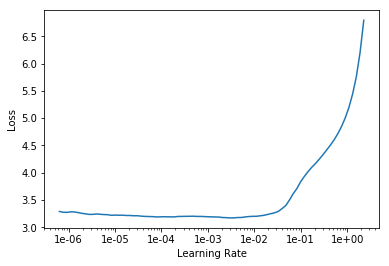

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.894423,3.381994,0.363769,05:19
1,2.835007,3.288344,0.382686,05:19
2,2.754470,3.223336,0.395803,05:19
3,2.528761,3.195553,0.404740,05:19
4,2.329433,3.201510,0.405895,05:19


In [0]:
learn.save('fine_tuned28')

In [0]:
learn.load('fine_tuned27')

In [0]:
learn.save_encoder('fine_tuned_28')

In [0]:
learn.load_encoder('fine_tuned_27')

In [0]:
lr = np.array([lrf/25., lrf/5., lrf])
my_cb = SaveBestModel(learn, lr, name='best')
learn.fit(lr, 2, cycle_len=2, cycle_mult=1, callbacks=[my_cb])

#Classifier

In [0]:
df.head()

In [0]:
#data_clas = load_data(path, 'data_clas.pkl')
data_clas.show_batch()

In [0]:
del learn
gc.collect()
bs=32

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_28')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


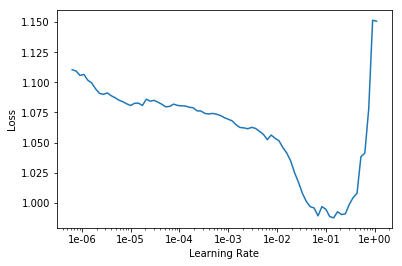

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#lr = 1e-02
#lr = np.array([lrf/5., lrf])
#my_cb = SaveBestModel(learn, lr, name='best_model')
learn.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))
#learn.fit(lr, 2, cycle_len=2, cycle_mult=1, callbacks=[my_cb])

epoch,train_loss,valid_loss,accuracy,time
0,0.757819,0.729542,0.715909,02:16
1,0.715617,0.714354,0.710227,02:35
2,0.695164,0.692751,0.727273,02:48
3,0.649035,0.690167,0.729167,02:19
4,0.677011,0.696567,0.725379,02:35


In [0]:
learn.save('28_clas1')

In [0]:
learn.save('27_clas')

In [0]:
learn.load('27_clas')

In [0]:
learn.load('/content/drive/My Drive/models/models/26_clas')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-02/(2.6**4),1e-02), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.673111,0.674411,0.729167,03:08


In [0]:
learn.save('28_clas-2')

In [0]:
learn.load('28_clas-2')

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(4e-03/(2.6**4),4e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.662201,0.693857,0.721591,04:23


In [0]:
learn.save('27_clas-2')

In [0]:
learn.unfreeze()


In [0]:
torch.cuda.empty_cache()

In [0]:
learn.fit_one_cycle(3, 4e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.675856,0.836476,0.715909,04:11
1,0.622854,0.697955,0.734848,05:07
2,0.362391,0.747737,0.725379,04:59


In [0]:
learn.save('28_clas-3')

In [0]:
learn.load('27_clas-3')

#Predictions

In [0]:
df_test.head()

In [0]:
len(df_test)

2924

In [0]:
learn.predict("I really hate that, it was awesome!")

(Category 0, tensor(0), tensor([0.6297, 0.0452, 0.3251]))

In [0]:
pred_test, label_test = learn.get_preds(DatasetType.Test, ordered=True)

In [0]:
data_clas.train_ds.y.classes

[0, 1, 2]

In [0]:
pred_test_ = pred_test.argmax(1)
pred_test_

tensor([0, 0, 2,  ..., 0, 2, 2])

In [0]:
pred_test_l = [data_clas.train_ds.y.classes[n] for n in pred_test_]
pred_test_l

In [0]:
len(pred_test_l)

2924

In [0]:
res = pd.Series(pred_test_l, index=df_test.index, name="sentiment")
res

In [0]:
res.index.name = "unique_hash"


In [0]:
pd.DataFrame(res).to_csv("sub5.csv")